In [95]:
import os

import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")


if not os.path.exists('data'):
    os.makedirs('data')

DATASET_OPTIONS = ["steel", "fetal_health"]
DATASET = "fetal_health"

In [96]:
if DATASET == "steel":
    if not os.path.exists('data/steel'):
        os.makedirs('data/steel')
    if not os.path.exists('data/steel/steel.train'):
        # fetch dataset
        steel_plates_faults = fetch_ucirepo(id=198)

        # data (as pandas dataframes)
        X = steel_plates_faults.data.features
        y = steel_plates_faults.data.targets

        # preprocess the targets
        # put the class as the index of the 1 in the row
        y = y.idxmax(axis=1)

        # convert to numbers
        y = y.astype('category').cat.codes

        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # saving the data
        X_train.to_csv('data/steel/steel.train', index=False)
        X_test.to_csv('data/steel/steel.test', index=False)
        y_train.to_csv('data/steel/steel.train.target', index=False)
        y_test.to_csv('data/steel/steel.test.target', index=False)

        print('Data saved in data/steel/steel.train, data/steel/steel.test, data/steel/steel.train.target, data/steel/steel.test.target')
    else:
        print('Data already exists in data/steel/steel.train, data/steel/steel.test, data/steel/steel.train.target, data/steel/steel.test.target')

    # load the data
    X_train = pd.read_csv('data/steel/steel.train')
    X_test = pd.read_csv('data/steel/steel.test')
    y_train = pd.read_csv('data/steel/steel.train.target')
    y_test = pd.read_csv('data/steel/steel.test.target')

In [97]:
if DATASET == "fetal_health":
    if not os.path.exists('data/fetal_health'):
        os.makedirs('data/fetal_health')

    if not os.path.exists('data/fetal_health/fetal_health.train'):
        # this data is meant to have been downloaded from kaggle
        fetal_health = pd.read_csv('data/fetal_health/fetal_health.csv')

        # split data
        X = fetal_health.drop(columns='fetal_health')
        y = fetal_health['fetal_health']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # saving the data
        X_train.to_csv('data/fetal_health/fetal_health.train', index=False)
        X_test.to_csv('data/fetal_health/fetal_health.test', index=False)
        y_train.to_csv('data/fetal_health/fetal_health.train.target', index=False)
        y_test.to_csv('data/fetal_health/fetal_health.test.target', index=False)

        print('Data saved in data/fetal_health/fetal_health.train, data/fetal_health/fetal_health.test, data/fetal_health/fetal_health.train.target, data/fetal_health/fetal_health.test.target')
    else:
        print('Data already exists in data/fetal_health/fetal_health.train, data/fetal_health/fetal_health.test, data/fetal_health/fetal_health.train.target, data/fetal_health/fetal_health.test.target')

    # load the data
    X_train = pd.read_csv('data/fetal_health/fetal_health.train')
    X_test = pd.read_csv('data/fetal_health/fetal_health.test')
    y_train = pd.read_csv('data/fetal_health/fetal_health.train.target')
    y_test = pd.read_csv('data/fetal_health/fetal_health.test.target')


Data already exists in data/fetal_health/fetal_health.train, data/fetal_health/fetal_health.test, data/fetal_health/fetal_health.train.target, data/fetal_health/fetal_health.test.target


In [98]:
print(f"Using dataset: {DATASET}")

Using dataset: fetal_health


In [99]:
# convert to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [100]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE} device')

Using cuda device


In [101]:
# normalize the data
def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

X_train = normalize(X_train)
X_test = normalize(X_test)

# extracting a validation set
VALIDATION_SIZE = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

# creating the tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.int64)
y_val = torch.tensor(y_val, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

# send to device
X_train = X_train.to(DEVICE)
X_val = X_val.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = y_train.to(DEVICE)
y_val = y_val.to(DEVICE)
y_test = y_test.to(DEVICE)

# create the dataset
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
# Define the model with dropout and batch normalization

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        """
        A Multi-Layer Perceptron model with 3 hidden layers of 256, 128, and 64 neurons each
        """
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_size)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        return self.softmax(x)

class DeepMLP(nn.Module):
    def __init__(self, input_size, output_size):
        """
        A Multi-Layer Perceptron model with 5 hidden layers of 512, 256, 128, 64, 32 neurons each
        """
        super(DeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, output_size)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        return self.softmax(x)

class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        """
        A Convolutional Neural Network model with 2 convolutional layers and 2 fully connected layers
        """
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * (input_size // 4), 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.model(x)
        return self.softmax(x)

## Example training loop

In [103]:
# hyperparameters
INPUT_SIZE = X_train.shape[1]
OUTPUT_SIZE = y_train.max() + 1
LEARNING_RATE = 0.0001
EPOCHS = 1000




In [104]:
# set the seed
torch.manual_seed(0)

# training the model
model = MLP(INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping parameters
early_stopping_patience = 100
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
training_losses = []
validation_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # scheduler.step(loss)

    model.eval()
    with torch.no_grad():
        train_loss = criterion(model(X_train), y_train)
        val_loss = criterion(model(X_val), y_val)
        test_loss = criterion(model(X_test), y_test)
        training_losses.append(float(train_loss))
        validation_losses.append(float(val_loss))
        
        print(f'Epoch {epoch}/{EPOCHS} Train loss: {train_loss:.4f} Val loss: {val_loss:.4f} Test loss: {test_loss:.4f}')
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch}')
                print(f'Best epoch: {best_epoch} with val loss: {best_val_loss:.4f}')
                break

Epoch 1/1000 Train loss: 1.1924 Val loss: 1.1885 Test loss: 1.1783
Epoch 2/1000 Train loss: 0.9934 Val loss: 0.9888 Test loss: 0.9699
Epoch 3/1000 Train loss: 0.9759 Val loss: 0.9721 Test loss: 0.9513
Epoch 4/1000 Train loss: 0.9730 Val loss: 0.9695 Test loss: 0.9483
Epoch 5/1000 Train loss: 0.9720 Val loss: 0.9685 Test loss: 0.9472
Epoch 6/1000 Train loss: 0.9715 Val loss: 0.9681 Test loss: 0.9466
Epoch 7/1000 Train loss: 0.9712 Val loss: 0.9678 Test loss: 0.9463
Epoch 8/1000 Train loss: 0.9710 Val loss: 0.9676 Test loss: 0.9461
Epoch 9/1000 Train loss: 0.9709 Val loss: 0.9675 Test loss: 0.9460
Epoch 10/1000 Train loss: 0.9708 Val loss: 0.9675 Test loss: 0.9459
Epoch 11/1000 Train loss: 0.9707 Val loss: 0.9674 Test loss: 0.9458
Epoch 12/1000 Train loss: 0.9707 Val loss: 0.9674 Test loss: 0.9458
Epoch 13/1000 Train loss: 0.9706 Val loss: 0.9673 Test loss: 0.9457
Epoch 14/1000 Train loss: 0.9706 Val loss: 0.9673 Test loss: 0.9457
Epoch 15/1000 Train loss: 0.9705 Val loss: 0.9673 Test lo

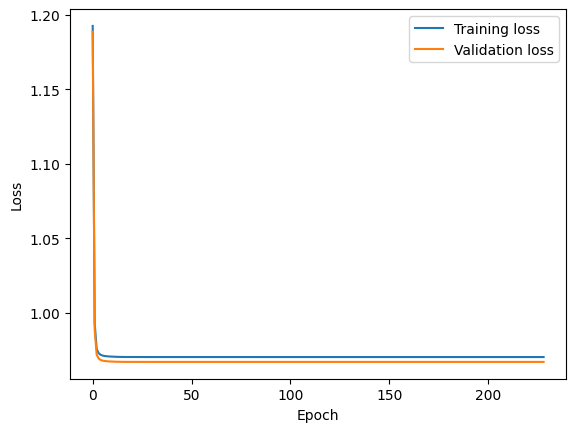

In [111]:
# graph the losses
import matplotlib.pyplot as plt
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [106]:
from sklearn.metrics import classification_report

model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1)
    print(classification_report(y_test.cpu(), y_pred.cpu()))

              precision    recall  f1-score   support

           1       0.80      1.00      0.89       340
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        33

    accuracy                           0.80       426
   macro avg       0.27      0.33      0.30       426
weighted avg       0.64      0.80      0.71       426



## Grid search

In [112]:
# additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
    """
    Compute accuracy, precision, recall, and f1 score (the macro average)

    Args:
    y_true: true labels
    y_pred: predicted labels

    Returns:
    a dictionary with the computed metrics
    """

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    out = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    return out


In [113]:
def train_model(model_specs, data_specs, epochs, early_stopping_patience=100, seed=0, logging=True, metric_specs=None, return_model=False):
    """
    Regular training loop with early stopping

    model_specs: dict
        model: torch.nn.Module
        criterion: torch.nn.Module
        optimizer: torch.optim.Optimizer
        scheduler: torch.optim.lr_scheduler
        train_loader: torch.utils.data.DataLoader
        val_loader: torch.utils.data.DataLoader
    data_specs: dict
        X_train: torch.Tensor
        y_train: torch.Tensor
        X_val: torch.Tensor
        y_val: torch.Tensor
    epochs: int
        Number of epochs to train the model
    early_stopping_patience: int
        Number of epochs to wait before early stopping when the key metric does not improve
    seed: int
        Random seed
    logging: bool
        Whether to print the training and validation losses
    metric_specs: dict
        metrics: function
            A function that takes y_true and y_pred and returns a dictionary of metrics
        larger_is_better: bool
            Whether a larger value of the key metric is better
        key_metric: str
            The key metric to use for early stopping
    return_model: bool
        Whether to return the trained model
    """
    torch.manual_seed(seed)
    model = model_specs['model']
    criterion = model_specs['criterion']
    optimizer = model_specs['optimizer']
    scheduler = model_specs['scheduler']
    train_loader = model_specs['train_loader']
    val_loader = model_specs['val_loader']

    X_train = data_specs['X_train']
    y_train = data_specs['y_train']
    X_val = data_specs['X_val']
    y_val = data_specs['y_val']

    if metric_specs is not None:
        get_metrics = metric_specs['metrics']
        larger_is_better = metric_specs['larger_is_better']
        key_metric = metric_specs['key_metric']
    else:
        get_metrics = None
        larger_is_better = False
        key_metric = None


    best_metric = float('-inf') if larger_is_better else float('inf')
    best_epoch = 0
    patience_counter = 0
    training_losses = []
    validation_losses = []
    training_key_metrics = []
    validation_key_metrics = []


    

    for epoch in range(1, epochs + 1):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        if scheduler is not None:
            scheduler.step(loss)

        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train), y_train)
            val_loss = criterion(model(X_val), y_val)
            training_losses.append(float(train_loss))
            validation_losses.append(float(val_loss))

            if metric_specs is not None:
                y_train_pred = model(X_train)
                y_val_pred = model(X_val)
                # evaluate the metrics on cpu
                metrics_train = get_metrics(y_train.cpu().numpy(), y_train_pred.cpu().argmax(dim=1).numpy())
                metrics_val = get_metrics(y_val.cpu().numpy(), y_val_pred.cpu().argmax(dim=1).numpy())
            
            if logging and epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs} Train loss: {train_loss:.4f} Val loss: {val_loss:.4f} ', end='')
                if metric_specs is not None:
                      print(f'Train {key_metric}: {metrics_train[key_metric]:.4f} Val {key_metric}: {metrics_val[key_metric]:.4f}')
                else:
                    print('')

            # Check for early stopping
            if metric_specs is not None:
                if larger_is_better:
                    val_metric = metrics_val[key_metric]
                    if val_metric > best_metric:
                        best_metric = val_metric
                        best_epoch = epoch
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= early_stopping_patience:
                            if logging:
                                print(f'Early stopping at epoch {epoch}')
                                print(f'Best epoch: {best_epoch} with val {key_metric}: {best_metric:.4f}')
                            break
                else:
                    val_metric = metrics_val[key_metric]
                    if val_metric < best_metric:
                        best_metric = val_metric
                        best_epoch = epoch
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= early_stopping_patience:
                            if logging:
                                print(f'Early stopping at epoch {epoch}')
                                print(f'Best epoch: {best_epoch} with val {key_metric}: {best_metric:.4f}')
                            break
            else:
                # loss
                if val_loss < best_metric:
                    best_metric = val_loss
                    best_epoch = epoch
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        if logging:
                            print(f'Early stopping at epoch {epoch}')
                            print(f'Best epoch: {best_epoch} with val loss: {best_metric:.4f}')
                        break

    return model if return_model else None

In [118]:
# grid search
from itertools import product

# this grid search is has been run before and the findings were that
# 1. Adam is better than SGD for this dataset
# 2. StepLR is better than ReduceLROnPlateau
# 3. 32 is the batch size is not that good

# the original grid search
# MODELS = [MLP, DeepMLP, CNN]
# SCHEDULERS = [None, optim.lr_scheduler.ReduceLROnPlateau, optim.lr_scheduler.StepLR]
# LEARNING_RATES = [0.0001, 0.001, 0.01]
# BATCH_SIZES = [32, 64, 128]
# OPTIMIZERS = [optim.Adam, optim.SGD]
# EPOCHS = 2000

# reduced grid search
MODELS = [MLP, DeepMLP, CNN]
SCHEDULERS = [None, optim.lr_scheduler.StepLR]
LEARNING_RATES = [0.0001, 0.001, 0.01]
BATCH_SIZES = [64, 128]
OPTIMIZERS = [optim.Adam]
EPOCHS = 2000

# all the combinations of the hyperparameters
combinations = list(product(MODELS, OPTIMIZERS, LEARNING_RATES, BATCH_SIZES, SCHEDULERS))


# metrics
metric_specs = {
    'metrics': compute_metrics,
    'larger_is_better': True,
    'key_metric': 'f1'
}

# training the models with the grid search
results = []

# try to read the results from the file
if os.path.exists('results.csv'):
    results = pd.read_csv('results.csv', index_col=0).to_dict(orient='records')
    print('Results loaded from results.csv')

Results loaded from results.csv


In [120]:
import time
START = time.time()
while True:
    if len(results) >= len(combinations):
        print('All combinations have been trained')
        break

    i = len(results)
    model, optimizer, lr, batch_size, scheduler = combinations[i]
    print(f'Combination {i + 1}/{len(combinations)}')
    print(f'lr: {lr} batch_size: {batch_size} scheduler: {scheduler} optimizer: {optimizer} model: {model.__name__}')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = model(INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)
    if scheduler is not None:
        if scheduler == optim.lr_scheduler.ReduceLROnPlateau:
            scheduler = scheduler(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
        else:
            scheduler = scheduler(optimizer, step_size=10, gamma=0.1)

    model_specs = {
        'model': model,
        'criterion': criterion,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loader': train_loader,
        'val_loader': val_loader
    }

    data_specs = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val
    }


    start = time.time()
    trained_model = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=False, return_model=True)
    if trained_model is not None:
        trained_model.eval()
        with torch.no_grad():
            y_test_pred = trained_model(X_test)
            metrics_test = compute_metrics(y_test.cpu().numpy(), y_test_pred.cpu().argmax(dim=1).numpy())
            results.append(metrics_test)
    
    print(f'Time taken: {time.time() - start:.2f}s')

print(f'Total time taken in minutes: {(time.time() - START) / 60:.2f}m')


All combinations have been trained
Total time taken in minutes: 0.00m


In [121]:
# take the best of each model based on the f1 score
results = pd.DataFrame(results)
results['model'] = [model.__name__ for model, _, _, _, _ in combinations]

best_results = results.groupby('model').max()
print(best_results)

# get the configuration of the best model of each type
best_mlp_config = combinations[results[results['model'] == 'MLP']['f1'].idxmax()]
best_deepmlp_config = combinations[results[results['model'] == 'DeepMLP']['f1'].idxmax()]
best_cnn_config = combinations[results[results['model'] == 'CNN']['f1'].idxmax()]

# save the results
results.to_csv('results.csv', index=False)
best_results.to_csv('best_results.csv')

# print the top 5 best mlps configuration settings
print('Top 5 MLP configurations')
top_5_mlp = results[results['model'] == 'MLP'].nlargest(5, 'f1')

# get the configurations
top_5_mlp_configs = [combinations[i] for i in top_5_mlp.index]
for i, config in enumerate(top_5_mlp_configs):
    print(config)

# print the top 5 best deepmlps configuration settings
print('Top 5 DeepMLP configurations')
top_5_deepmlp = results[results['model'] == 'DeepMLP'].nlargest(5, 'f1')

# get the configurations
top_5_deepmlp_configs = [combinations[i] for i in top_5_deepmlp.index]
for i, config in enumerate(top_5_deepmlp_configs):
    print(config)

# print the top 5 best cnns configuration settings
print('Top 5 CNN configurations')
top_5_cnn = results[results['model'] == 'CNN'].nlargest(5, 'f1')

# get the configurations
top_5_cnn_configs = [combinations[i] for i in top_5_cnn.index]
for i, config in enumerate(top_5_cnn_configs):
    print(config)


         precision    recall        f1
model                                 
CNN       0.266041  0.333333  0.295909
DeepMLP   0.832020  0.848236  0.835378
MLP       0.855347  0.853191  0.850109
Top 5 MLP configurations
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 128, <class 'torch.optim.lr_scheduler.StepLR'>)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.01, 128, None)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.01, 128, <class 'torch.optim.lr_scheduler.StepLR'>)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 64, None)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.0001, 64, None)
Top 5 DeepMLP configurations
(<class '__main__.DeepMLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 128, <class 'torch.optim.lr_scheduler.StepLR'>)
(<class '__main__.DeepMLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 128, None)
(<class '__main__.DeepMLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 64, None)
(<class '__main__.DeepML

In [122]:
# evaluating the best models on the test set
best_mlp = best_mlp_config[0](INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
best_deepmlp = best_deepmlp_config[0](INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
best_cnn = best_cnn_config[0](INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)

data_specs = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val
}

# mlp
train_loader = DataLoader(train_dataset, batch_size=best_mlp_config[3], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_mlp_config[3], shuffle=False)

optimizer = best_mlp_config[1](best_mlp.parameters(), lr=best_mlp_config[2])
if best_mlp_config[4] is not None:
    if best_mlp_config[4] == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = best_mlp_config[4](optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    else:
        scheduler = best_mlp_config[4](optimizer, step_size=10, gamma=0.1)
else:
    scheduler = None

model_specs = {
    'model': best_mlp,
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'scheduler': scheduler,
    'train_loader': train_loader,
    'val_loader': val_loader
}

best_mlp = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=True, return_model=True)

# deepmlp
train_loader = DataLoader(train_dataset, batch_size=best_deepmlp_config[3], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_deepmlp_config[3], shuffle=False)

optimizer = best_deepmlp_config[1](best_deepmlp.parameters(), lr=best_deepmlp_config[2])
if best_deepmlp_config[4] is not None:
    if best_deepmlp_config[4] == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = best_deepmlp_config[4](optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    else:
        scheduler = best_deepmlp_config[4](optimizer, step_size=10, gamma=0.1)
else:
    scheduler = None

model_specs = {
    'model': best_deepmlp,
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'scheduler': scheduler,
    'train_loader': train_loader,
    'val_loader': val_loader
}

best_deepmlp = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=True, return_model=True)

# cnn
train_loader = DataLoader(train_dataset, batch_size=best_cnn_config[3], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_cnn_config[3], shuffle=False)

optimizer = best_cnn_config[1](best_cnn.parameters(), lr=best_cnn_config[2])
if best_cnn_config[4] is not None:
    if best_cnn_config[4] == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = best_cnn_config[4](optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    else:
        scheduler = best_cnn_config[4](optimizer, step_size=10, gamma=0.1)
else:
    scheduler = None

model_specs = {
    'model': best_cnn,
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'scheduler': scheduler,
    'train_loader': train_loader,
    'val_loader': val_loader
}

best_cnn = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=True, return_model=True)

Epoch 10/2000 Train loss: 0.8747 Val loss: 0.8569 Train f1: 0.8104 Val f1: 0.8045
Epoch 20/2000 Train loss: 0.8364 Val loss: 0.8193 Train f1: 0.8453 Val f1: 0.8587
Epoch 30/2000 Train loss: 0.8252 Val loss: 0.8076 Train f1: 0.8540 Val f1: 0.8911
Epoch 40/2000 Train loss: 0.8179 Val loss: 0.8057 Train f1: 0.8734 Val f1: 0.8768
Epoch 50/2000 Train loss: 0.8103 Val loss: 0.7951 Train f1: 0.8712 Val f1: 0.9205
Epoch 60/2000 Train loss: 0.8087 Val loss: 0.7970 Train f1: 0.8809 Val f1: 0.8982
Epoch 70/2000 Train loss: 0.8048 Val loss: 0.7967 Train f1: 0.8826 Val f1: 0.9089
Epoch 80/2000 Train loss: 0.7996 Val loss: 0.8026 Train f1: 0.8983 Val f1: 0.8600
Epoch 90/2000 Train loss: 0.7969 Val loss: 0.7998 Train f1: 0.9040 Val f1: 0.8787
Epoch 100/2000 Train loss: 0.7945 Val loss: 0.8039 Train f1: 0.9111 Val f1: 0.8461
Epoch 110/2000 Train loss: 0.7904 Val loss: 0.7986 Train f1: 0.9136 Val f1: 0.8715
Epoch 120/2000 Train loss: 0.7916 Val loss: 0.8031 Train f1: 0.9095 Val f1: 0.8588
Epoch 130/200

In [125]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X, y):
    """
    Evaluate the model on the given data

    Args:
    model: torch.nn.Module
    X: torch.Tensor
    y: torch.Tensor

    Returns:
    accuracy: float
    classification_report: str
    """
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        y_pred = y_pred.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
        accuracy = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred)
    return accuracy, report

# evaluate the best models
accuracy_mlp, report_mlp = evaluate_model(best_mlp, X_test, y_test)
accuracy_deepmlp, report_deepmlp = evaluate_model(best_deepmlp, X_test, y_test)
accuracy_cnn, report_cnn = evaluate_model(best_cnn, X_test, y_test)

print('MLP')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(report_mlp)

MLP
Accuracy: 0.9061
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       340
           2       0.67      0.70      0.69        53
           3       0.84      0.79      0.81        33

    accuracy                           0.91       426
   macro avg       0.82      0.81      0.82       426
weighted avg       0.91      0.91      0.91       426



In [126]:
print('DeepMLP')
print(f'Accuracy: {accuracy_deepmlp:.4f}')
print(report_deepmlp)

DeepMLP
Accuracy: 0.9131
              precision    recall  f1-score   support

           1       0.96      0.95      0.96       340
           2       0.66      0.81      0.73        53
           3       0.92      0.70      0.79        33

    accuracy                           0.91       426
   macro avg       0.85      0.82      0.83       426
weighted avg       0.92      0.91      0.91       426



In [127]:
print('CNN')
print(f'Accuracy: {accuracy_cnn:.4f}')
print(report_cnn)

CNN
Accuracy: 0.7981
              precision    recall  f1-score   support

           1       0.80      1.00      0.89       340
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        33

    accuracy                           0.80       426
   macro avg       0.27      0.33      0.30       426
weighted avg       0.64      0.80      0.71       426



In [128]:
# baseline dummy model
from sklearn.dummy import DummyClassifier


dummy = DummyClassifier(strategy="uniform", random_state=0)
dummy.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
y_pred = dummy.predict(X_test.cpu().numpy())
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
print(f'Baseline accuracy: {accuracy:.4f}')
print(classification_report(y_test.cpu().numpy(), y_pred))

Baseline accuracy: 0.3967
              precision    recall  f1-score   support

           1       0.83      0.37      0.51       340
           2       0.19      0.53      0.28        53
           3       0.12      0.45      0.19        33

    accuracy                           0.40       426
   macro avg       0.38      0.45      0.33       426
weighted avg       0.70      0.40      0.46       426



In [129]:
# baseline logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=0)
logreg.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
y_pred = logreg.predict(X_test.cpu().numpy())
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
print(f'Logistic regression accuracy: {accuracy:.4f}')
print(classification_report(y_test.cpu().numpy(), y_pred))

Logistic regression accuracy: 0.8803
              precision    recall  f1-score   support

           1       0.95      0.94      0.94       340
           2       0.58      0.58      0.58        53
           3       0.67      0.79      0.72        33

    accuracy                           0.88       426
   macro avg       0.73      0.77      0.75       426
weighted avg       0.88      0.88      0.88       426

